# Libraries

In [1]:
import os
from io import StringIO 
import pandas as pd
from urllib import request
from bs4 import BeautifulSoup
import re
import plotly.plotly as py
import plotly.graph_objs as go
import requests
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import nltk
from nltk import word_tokenize, everygrams
from nltk.util import ngrams
import lxml
from tabulate import tabulate
import numpy as np

# Obtain data

## Function Definitions

In [2]:
def single_read_in_text(file_path,file_name):
    '''
    input:
    file_path: path of a individule csv file e.g. location of 21centfoxinc_sec_files.csv
    file_name: name of the file e.g 21centfoxinc_sec_files.csv
    
    output:
    a sigle pandas dataframe with all the original columns from the input file + a column for the 'cleaned' data
    
    dev:
    1) can add more output columns for features
    2) can further clean the data 
    
    '''
    
    ## read in single csv to pandas 
    individule_csv = pd.read_csv(file_path+"/"+file_name)
    processed_file = []
    
    ## create a connection with the url link and readin the raw file
    for url in individule_csv['sec_full_path']:
        print(url)
        text = request.urlopen(url).read().decode('utf8')
        soup = BeautifulSoup(text,'html.parser')
        
        ## clean raw text
        
        ## 1. remove html tags 
        ## 2. break the text by "\n"
        ## 3. remove the spaces in the front of and after each "\n"

        cleaned_text = '%%'.join(list(filter(None,
                                             [re.sub('[\t]+', ' ', i.strip()) for 
                                              i in soup.text.split('\n')])))
        
        ## find all tables
        raw_table = soup.find_all('table')
        
        
        ## clean all tables
        if not raw_table:

            cleaned_table = []
        else:
            
            '''
            cleaned_table = [[k[0],''.join(k[1:])] 
                             for k in [[j.replace('\n',"").strip() for j in re.split('  +',i)] for i in raw_table[0].get_text().split('\n\n')]]
            
            '''
     
            
            #cleaned_table = [re.split('  +',j) for j in [i for i in [h.get_text().split('\n\n') for h in raw_table]]]
            cleaned_table = [[[k[0],''.join(k[1:])] for k in 
             [[j.replace('\n',"").strip() 
               for j in re.split('  +',i)] 
              for i in l.get_text().split('\n\n')]] for l in raw_table]
            
            
            '''
            
            cleaned_table = [[k[0],''.join(k[1:])] 
                             for k in [[j.replace('\n',"").strip() 
                                        for j in re.split('  +',i)] 
                                       for i in [h.get_text().split('\n\n') for h in raw_table]]]            
            '''
        ## search the text
        Item_text = soup.findAll(text=re.compile("Item "))
        Item_category = [re.search('(?<=Item ).*', i).group(0) for i in Item_text]

        
        processed_file.append([url,
                               text,
                               cleaned_text,
                               raw_table,
                               cleaned_table,
                               Item_text,
                               Item_category])
    
    
    ## merge back to the original read in dataframe 
    clean_texts_df = pd.DataFrame(processed_file)
    clean_texts_df.columns = ['sec_full_path', 'text', 'cleaned_text',
                              'raw_table','cleaned_table',
                              'Item_text', 'Item_category']
    merged_df = pd.merge(left = individule_csv, right = clean_texts_df, on = 'sec_full_path')
    
    ## add one more column to indicate the file name 
    merged_df['file_name'] = file_name
    return merged_df
def folder_read_in_text(folder_path, ext = '.csv'):
    '''
    input: 
    folder_path: path of a individule csv file e.g. location of 21centfoxinc_sec_files.csv
    ext: extension of the files that are interested, default to be .csv 
    
    output:
    a sigle pandas dataframe with all the original columns from all the input files inside the folder
    + a column for the 'cleaned' data
    + a column for the file name 
    
    Utilize the single_read_in_text function 
    '''
    file = []
    direc = folder_path 

    # Select only files with the ext extension
    txt_files = [i for i in os.listdir(direc) if os.path.splitext(i)[1] == ext]
    temp_df = pd.DataFrame()
    
    ## Utilize the single_read_in_text function to process data

    for i in txt_files:
        temp_df = temp_df.append(single_read_in_text(file_path = folder_path,file_name = i), ignore_index=True)
    return temp_df

## Function Call

In [3]:
## test file 
working_file = folder_read_in_text(folder_path='C:/Users/li haoran/Documents/GitHub/Capstone_Vanguard_NLP_Prediction/sample_inputs',
                                   ext = '.csv')

https://www.sec.gov/Archives/edgar/data/732712/0000950133-94-000018.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950172-94-000010.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000061.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000079.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000108.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-94-000006.txt


In [4]:
working_file

,fdate,cik,findexdate,form,coname,fsize,doccount,sec_full_path,text,cleaned_text,raw_table,cleaned_table,Item_text,Item_category,file_name
0,1/21/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3399,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table> <s> <c> Date of Report: ...,"[[[Date of Report:, January 20, 1994], [Exact ...",[ 2 Item 5. Other Events. Bell At...,[5. Other Events.],sample_inputs.csv
1,2/1/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2923,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[ SECURITIES AND EXCHANGE COMMISSION...,[5. Other Events.],sample_inputs.csv
2,2/9/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,18580,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table> <caption> ...,"[[[, ], [, Three months endedYear endedDecembe...",[ 2 Item 5. Other Events. Bell Atlantic Cor...,"[5. Other Events., 7. Financial Statements and...",sample_inputs.csv
3,2/14/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2930,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table> <s> <c> Date of Report: ...,"[[[Date of Report:, February 14, 1994], [Exact...",[ 3 Item 5. Other Events. Bell At...,[5. Other Events.],sample_inputs.csv
4,2/24/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3196,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[ 2 Item 5. Other Events. Bell Atlant...,[5. Other Events.],sample_inputs.csv
5,3/23/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,6014,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[ 2 Item 5. Other Events. Attached as...,[5. Other Events.],sample_inputs.csv


In [6]:
print(working_file['text'][0])

-----BEGIN PRIVACY-ENHANCED MESSAGE-----
Proc-Type: 2001,MIC-CLEAR
Originator-Name: keymaster@town.hall.org
Originator-Key-Asymmetric:
 MFkwCgYEVQgBAQICAgADSwAwSAJBALeWW4xDV4i7+b6+UyPn5RtObb1cJ7VkACDq
 pKb9/DClgTKIm08lCfoilvi9Wl4SODbR1+1waHhiGmeZO8OdgLUCAwEAAQ==
MIC-Info: RSA-MD5,RSA,
 nHm54/IDWXBYdWA9FS8wCWCcu8BzuiRmNsr32/KQgrsVp1CF9q8g0bpugEVSkjnW
 KEpCfq8D/eo0Xi2JqHPTPQ==

<IMS-DOCUMENT>0000950133-94-000018.txt : 19940124
<IMS-HEADER>0000950133-94-000018.hdr.sgml : 19940124
ACCESSION NUMBER:		0000950133-94-000018
CONFORMED SUBMISSION TYPE:	8-K
PUBLIC DOCUMENT COUNT:		1
CONFORMED PERIOD OF REPORT:	19940120
ITEM INFORMATION:		1
FILED AS OF DATE:		19940121

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			BELL ATLANTIC CORP
		CENTRAL INDEX KEY:			0000732712
		STANDARD INDUSTRIAL CLASSIFICATION:	4813
		IRS NUMBER:				232259884
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		8-K
		SEC ACT:		34
		SEC FILE NUMBER:	001-08606
		FILM NUMBER:		9450215

In [20]:
working_file = folder_read_in_text(folder_path='C:/Users/li haoran/Documents/GitHub/Capstone_Vanguard_NLP_Prediction/Inputs',
                                   ext = '.csv')

https://www.sec.gov/Archives/edgar/data/732712/0000950133-94-000018.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950172-94-000010.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000061.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000079.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000108.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-94-000006.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-000587.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-94-000009.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-000824.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-94-000014.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-001534.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-94-000017.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-002093.txt
https://www.sec.gov/Archives/edgar/data/732712/0000732712-95-000

https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-004377.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-005648.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950130-02-003892.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950123-02-006330.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-008709.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-008892.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-009527.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-009530.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-010485.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-011940.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-012975.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-014129.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-014130.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950134-02-015

https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-238309.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-245448.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-247678.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-248715.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-251425.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-06-256227.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-001162.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-006937.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-014634.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-016525.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-020398.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-044126.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-048544.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-07-094

https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-057878.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-093344.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-104504.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-113952.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-134085.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-173294.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-194187.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-196160.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-201011.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-248070.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-276677.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-280401.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-328252.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-11-332

https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-433999.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-473367.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-527195.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-549165.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-551222.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-562197.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-586418.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-616451.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-617604.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-633746.txt
https://www.sec.gov/Archives/edgar/data/732712/0000898822-16-000404.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-657235.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-664131.txt
https://www.sec.gov/Archives/edgar/data/732712/0001193125-16-664

In [21]:
working_file.to_csv('C:/Users/li haoran/Desktop/sec files/full_data_verizon.csv', sep='|', encoding='utf-8')

In [22]:
working_file_subset = working_file[['fdate','cik','findexdate','form','coname','raw_table','cleaned_table','Item_text','Item_category']]
working_file_subset.to_csv('C:/Users/li haoran/Desktop/sec files/table_item_data_verizon.csv', sep='|', encoding='utf-8')

In [16]:
working_file['cleaned_text'][2].split('%%')

"-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc-Type: 2001,MIC-CLEAR%%Originator-Name: keymaster@town.hall.org%%Originator-Key-Asymmetric:%%MFkwCgYEVQgBAQICAgADSwAwSAJBALeWW4xDV4i7+b6+UyPn5RtObb1cJ7VkACDq%%pKb9/DClgTKIm08lCfoilvi9Wl4SODbR1+1waHhiGmeZO8OdgLUCAwEAAQ==%%MIC-Info: RSA-MD5,RSA,%%GMQAlRnJvVLSy5tYNW+mtKTV/65v5fFNLQ176DahHwPr/SOIt/Pk794jNRnCxAXZ%%98Wfg25vcdOAKEqvBAUf7w==%%0000893220-94-000061.txt : 19940210%%0000893220-94-000061.hdr.sgml : 19940210%%ACCESSION NUMBER: 0000893220-94-000061%%CONFORMED SUBMISSION TYPE: 8-K%%PUBLIC DOCUMENT COUNT: 2%%CONFORMED PERIOD OF REPORT: 19940121%%ITEM INFORMATION: 5%%FILED AS OF DATE: 19940209%%FILER:%%COMPANY DATA:%%COMPANY CONFORMED NAME: BELL ATLANTIC CORP%%CENTRAL INDEX KEY: 0000732712%%STANDARD INDUSTRIAL CLASSIFICATION: 4813%%IRS NUMBER: 232259884%%STATE OF INCORPORATION: DE%%FISCAL YEAR END: 1231%%FILING VALUES:%%FORM TYPE: 8-K%%SEC ACT: 34%%SEC FILE NUMBER: 001-08606%%FILM NUMBER: 94505225%%BUSINESS ADDRESS:%%STREET 1: 1717 ARCH ST%

In [13]:
working_file['Item_text'][2]

["   2\nItem 5. Other Events.\n\nBell Atlantic Corporation (the Company) on January 21, 1994 announced that it\nwas reporting 1993 earnings of $3.22 per share, which included a one-time,\nnon-cash charge of $.19 per share, or $85.0 million, for the adoption of a\nchange in the method of accounting for postemployment benefits, versus $3.13\nper share in 1992.  Excluding this charge and the impact of 1993 tax\nlegislation, 1993 earnings per share would have been $3.44.\n\n         In addition to the one-time, non-cash charge for the change in the\nmethod of accounting for postemployment benefits (Statement of Financial\nAccounting Standards No. 112 [FAS 112]) and a net decrease of $.03 per share,\nor $11.4 million, for the effect of 1993 federal tax legislation, results for\n1993 also included extraordinary charges of $.13 per share, or $58.4 million,\nfor early extinguishment of debt; and a net benefit of $.11 per share, or $51.0\nmillion, for other previously reported items.  Earnings 

In [4]:
working_file['raw_table'][0]

[<table>
 <s> <c>
 Date of Report:                              January 20, 1994
 
 Exact name of registrant
 as specified in its charter:                 BELL ATLANTIC CORPORATION
 
 Commission File No.:                         1-8606
 
 State of Incorporation:                      Delaware
 
 IRS Employer Identification No.:             23-2259884
 
 Address of principal
 executive offices:                           1717 Arch Street
                                              Philadelphia, Pennsylvania
 Zip Code                                     19103
 
 Registrant's telephone number,
 including area code:                         (215) 963-6000
 
 Former name or former address,
 if changed since last report:                N/A
 </c></s></table>]

In [5]:
working_file['cleaned_table'][0]

[[['Date of Report:', 'January 20, 1994'],
  ['Exact name of registrantas specified in its charter:',
   'BELL ATLANTIC CORPORATION'],
  ['Commission File No.:', '1-8606'],
  ['State of Incorporation:', 'Delaware'],
  ['IRS Employer Identification No.:', '23-2259884'],
  ['Address of principalexecutive offices:',
   '1717 Arch StreetPhiladelphia, PennsylvaniaZip Code19103'],
  ["Registrant's telephone number,including area code:", '(215) 963-6000'],
  ['Former name or former address,if changed since last report:', 'N/A']]]

In [7]:
pd.DataFrame(working_file['cleaned_table'][0][0])

,0,1
0,Date of Report:,"January 20, 1994"
1,Exact name of registrantas specified in its ch...,BELL ATLANTIC CORPORATION
2,Commission File No.:,1-8606
3,State of Incorporation:,Delaware
4,IRS Employer Identification No.:,23-2259884
5,Address of principalexecutive offices:,"1717 Arch StreetPhiladelphia, PennsylvaniaZip ..."
6,"Registrant's telephone number,including area c...",(215) 963-6000
7,"Former name or former address,if changed since...",N/A


In [8]:
working_file['cleaned_table'][1]

[]

In [9]:
working_file['cleaned_table'][2][0]

[['', ''],
 ['',
  'Three months endedYear endedDecember 31December 31-------------------------------------19931992*19931992*'],
 ['',
  'OPERATING REVENUES Communications andRelated Services$3,194.5$3,117.9$12,534.8$12,164.6 Financial, Real Estate,and Other Services122.7156.3455.4553.8'],
 ['', 'Total operating revenues3,317.23,274.212,990.212,718.4'],
 ['OPERATING EXPENSES Employee costs, including',
  'benefits and taxes1,019.01,004.34,027.63,941.5 Depreciation andamortization649.8597.22,545.12,417.4 Other1,041.21,154.63,619.93,853.3'],
 ['', 'Total operating expenses2,710.02,756.110,192.610,212.2'],
 ['OPERATING INCOME', '607.2518.12,797.62,506.2'],
 ['Other income and',
  'expense, net29.142.388.1214.4Interest expense, excludingFinancial Services141.3162.3612.1694.9Income before provision for incometaxes, extraordinary item, andcumulative effect of changes inaccounting principles495.0398.12,273.62,025.7Provision for income taxes157.870.6792.0643.5Income before extraordinary iteman

In [7]:
working_file['cleaned_table'][3]

[[['Date of Report:', 'February 14, 1994'],
  ['Exact name of registrantas specified in its charter:',
   'BELL ATLANTIC CORPORATION'],
  ['Commission File No.:', '1-8606'],
  ['State of Incorporation:', 'Delaware'],
  ['IRS Employer Identification No.:', '23-2259884'],
  ['Address of principalexecutive offices:',
   '1717 Arch StreetPhiladelphia, PennsylvaniaZip Code19103'],
  ["Registrant's telephone number,including area code:", '(215) 963-6000'],
  ['Former name or former address,if changed since last report:', 'N/A']]]

In [14]:
working_file['raw_table'][2][0]

<table>
<caption>
                                                           Three months ended                         Year ended
                                                               December 31                            December 31    
                                                           ------------------                     -------------------
                                                        1993                1992*              1993                1992*

<s> <c> <c> <c> <c>
OPERATING REVENUES
 Communications and
  Related Services                                    $3,194.5             $3,117.9          $12,534.8            $12,164.6
 Financial, Real Estate,
  and Other Services                                     122.7                156.3              455.4                553.8

     Total operating revenues                          3,317.2              3,274.2           12,990.2             12,718.4

OPERATING EXPENSES
 Employee costs, including
   bene

In [15]:
working_file['raw_table'][2][0].get_text()

'\n\n                                                           Three months ended                         Year ended\n                                                               December 31                            December 31    \n                                                           ------------------                     -------------------\n                                                        1993                1992*              1993                1992*\n\n    \nOPERATING REVENUES\n Communications and\n  Related Services                                    $3,194.5             $3,117.9          $12,534.8            $12,164.6\n Financial, Real Estate,\n  and Other Services                                     122.7                156.3              455.4                553.8\n\n     Total operating revenues                          3,317.2              3,274.2           12,990.2             12,718.4\n\nOPERATING EXPENSES\n Employee costs, including\n   benefits and tax

In [20]:
working_file['raw_table'][2][0].get_text().split('\n\n')[0]

''

In [22]:
working_file['raw_table'][2][0].get_text().split('\n\n')[1]

'                                                           Three months ended                         Year ended\n                                                               December 31                            December 31    \n                                                           ------------------                     -------------------\n                                                        1993                1992*              1993                1992*'

In [23]:
working_file['raw_table'][2][0].get_text().split('\n\n')[3]

'     Total operating revenues                          3,317.2              3,274.2           12,990.2             12,718.4'

In [26]:
working_file['raw_table'][2][0].get_text().split('\n\n')[4]

'OPERATING EXPENSES\n Employee costs, including\n   benefits and taxes                                  1,019.0              1,004.3            4,027.6              3,941.5\n Depreciation and\n   amortization                                          649.8                597.2            2,545.1              2,417.4\n Other                                                 1,041.2              1,154.6            3,619.9              3,853.3'

In [25]:
print(working_file['raw_table'][2][0].get_text().split('\n\n')[4])

OPERATING EXPENSES
 Employee costs, including
   benefits and taxes                                  1,019.0              1,004.3            4,027.6              3,941.5
 Depreciation and
   amortization                                          649.8                597.2            2,545.1              2,417.4
 Other                                                 1,041.2              1,154.6            3,619.9              3,853.3


In [12]:
[ [[j.replace('\n',"").strip() 
   for j in re.split('  +',i)] 
  for i in working_file['raw_table'][2][0].get_text().split('\n\n')]]

[[[''],
  ['',
   'Three months ended',
   'Year ended',
   'December 31',
   'December 31',
   '',
   '------------------',
   '-------------------',
   '1993',
   '1992*',
   '1993',
   '1992*'],
  ['',
   'OPERATING REVENUES Communications and',
   'Related Services',
   '$3,194.5',
   '$3,117.9',
   '$12,534.8',
   '$12,164.6 Financial, Real Estate,',
   'and Other Services',
   '122.7',
   '156.3',
   '455.4',
   '553.8'],
  ['',
   'Total operating revenues',
   '3,317.2',
   '3,274.2',
   '12,990.2',
   '12,718.4'],
  ['OPERATING EXPENSES Employee costs, including',
   'benefits and taxes',
   '1,019.0',
   '1,004.3',
   '4,027.6',
   '3,941.5 Depreciation and',
   'amortization',
   '649.8',
   '597.2',
   '2,545.1',
   '2,417.4 Other',
   '1,041.2',
   '1,154.6',
   '3,619.9',
   '3,853.3'],
  ['',
   'Total operating expenses',
   '2,710.0',
   '2,756.1',
   '10,192.6',
   '10,212.2'],
  ['OPERATING INCOME', '607.2', '518.1', '2,797.6', '2,506.2'],
  ['Other income and',
   '

In [11]:
[[k[0],''.join(k[1:])] for k in 
 [[j.replace('\n',"").strip() 
   for j in re.split('  +',i)] 
  for i in working_file['raw_table'][2][0].get_text().split('\n\n')]]

[['', ''],
 ['',
  'Three months endedYear endedDecember 31December 31-------------------------------------19931992*19931992*'],
 ['',
  'OPERATING REVENUES Communications andRelated Services$3,194.5$3,117.9$12,534.8$12,164.6 Financial, Real Estate,and Other Services122.7156.3455.4553.8'],
 ['', 'Total operating revenues3,317.23,274.212,990.212,718.4'],
 ['OPERATING EXPENSES Employee costs, including',
  'benefits and taxes1,019.01,004.34,027.63,941.5 Depreciation andamortization649.8597.22,545.12,417.4 Other1,041.21,154.63,619.93,853.3'],
 ['', 'Total operating expenses2,710.02,756.110,192.610,212.2'],
 ['OPERATING INCOME', '607.2518.12,797.62,506.2'],
 ['Other income and',
  'expense, net29.142.388.1214.4Interest expense, excludingFinancial Services141.3162.3612.1694.9Income before provision for incometaxes, extraordinary item, andcumulative effect of changes inaccounting principles495.0398.12,273.62,025.7Provision for income taxes157.870.6792.0643.5Income before extraordinary iteman

In [330]:
mystr = StringIO(working_file[0:1]['table'][0][0].get_text())
df = pd.read_csv(mystr, header=None, delimiter=':')
df

,0,1
0,Date of Report,"January 20, 1994"
1,Exact name of registrant,NaN
2,as specified in its charter,BELL ATLANTIC CORPORATION
3,Commission File No.,1-8606
4,State of Incorporation,Delaware
5,IRS Employer Identification No.,23-2259884
6,Address of principal,NaN
7,executive offices,1717 Arch Street
8,P...,NaN
9,Zip Code 1...,NaN


In [364]:
working_file[0:1]['raw_table'][0][0]

<table>
<s> <c>
Date of Report:                              January 20, 1994

Exact name of registrant
as specified in its charter:                 BELL ATLANTIC CORPORATION

Commission File No.:                         1-8606

State of Incorporation:                      Delaware

IRS Employer Identification No.:             23-2259884

Address of principal
executive offices:                           1717 Arch Street
                                             Philadelphia, Pennsylvania
Zip Code                                     19103

Registrant's telephone number,
including area code:                         (215) 963-6000

Former name or former address,
if changed since last report:                N/A
</c></s></table>

In [337]:
working_file[0:1]['raw_table'][0][0].get_text()

"\n \nDate of Report:                              January 20, 1994\n\nExact name of registrant\nas specified in its charter:                 BELL ATLANTIC CORPORATION\n\nCommission File No.:                         1-8606\n\nState of Incorporation:                      Delaware\n\nIRS Employer Identification No.:             23-2259884\n\nAddress of principal\nexecutive offices:                           1717 Arch Street\n                                             Philadelphia, Pennsylvania\nZip Code                                     19103\n\nRegistrant's telephone number,\nincluding area code:                         (215) 963-6000\n\nFormer name or former address,\nif changed since last report:                N/A\n"

In [338]:
pd.DataFrame([[k[0],''.join(k[1:])] for k in 
 [[j.replace('\n',"").strip() 
   for j in re.split('  +',i)] 
  for i in working_file[0:1]['raw_table'][0][0].get_text().split('\n\n')]])

,0,1
0,Date of Report:,"January 20, 1994"
1,Exact name of registrantas specified in its ch...,BELL ATLANTIC CORPORATION
2,Commission File No.:,1-8606
3,State of Incorporation:,Delaware
4,IRS Employer Identification No.:,23-2259884
5,Address of principalexecutive offices:,"1717 Arch StreetPhiladelphia, PennsylvaniaZip ..."
6,"Registrant's telephone number,including area c...",(215) 963-6000
7,"Former name or former address,if changed since...",N/A


In [419]:
working_file['raw_table'][2]

[<table>
 <caption>
                                                            Three months ended                         Year ended
                                                                December 31                            December 31    
                                                            ------------------                     -------------------
                                                         1993                1992*              1993                1992*
 
 <s> <c> <c> <c> <c>
 OPERATING REVENUES
  Communications and
   Related Services                                    $3,194.5             $3,117.9          $12,534.8            $12,164.6
  Financial, Real Estate,
   and Other Services                                     122.7                156.3              455.4                553.8
 
      Total operating revenues                          3,317.2              3,274.2           12,990.2             12,718.4
 
 OPERATING EXPENSES
  Employee costs,

In [420]:
working_file['cleaned_table'][2]

[[['', ''],
  ['',
   'Three months endedYear endedDecember 31December 31-------------------------------------19931992*19931992*'],
  ['',
   'OPERATING REVENUES Communications andRelated Services$3,194.5$3,117.9$12,534.8$12,164.6 Financial, Real Estate,and Other Services122.7156.3455.4553.8'],
  ['', 'Total operating revenues3,317.23,274.212,990.212,718.4'],
  ['OPERATING EXPENSES Employee costs, including',
   'benefits and taxes1,019.01,004.34,027.63,941.5 Depreciation andamortization649.8597.22,545.12,417.4 Other1,041.21,154.63,619.93,853.3'],
  ['', 'Total operating expenses2,710.02,756.110,192.610,212.2'],
  ['OPERATING INCOME', '607.2518.12,797.62,506.2'],
  ['Other income and',
   'expense, net29.142.388.1214.4Interest expense, excludingFinancial Services141.3162.3612.1694.9Income before provision for incometaxes, extraordinary item, andcumulative effect of changes inaccounting principles495.0398.12,273.62,025.7Provision for income taxes157.870.6792.0643.5Income before extraord

In [429]:
[[j for j in re.split('  +',i)] 
           for i in working_file['raw_table'][2][0].get_text().split('\n\n')]

[[''],
 ['',
  'Three months ended',
  'Year ended\n',
  'December 31',
  'December 31',
  '\n',
  '------------------',
  '-------------------\n',
  '1993',
  '1992*',
  '1993',
  '1992*'],
 ['',
  '\nOPERATING REVENUES\n Communications and\n',
  'Related Services',
  '$3,194.5',
  '$3,117.9',
  '$12,534.8',
  '$12,164.6\n Financial, Real Estate,\n',
  'and Other Services',
  '122.7',
  '156.3',
  '455.4',
  '553.8'],
 ['',
  'Total operating revenues',
  '3,317.2',
  '3,274.2',
  '12,990.2',
  '12,718.4'],
 ['OPERATING EXPENSES\n Employee costs, including\n',
  'benefits and taxes',
  '1,019.0',
  '1,004.3',
  '4,027.6',
  '3,941.5\n Depreciation and\n',
  'amortization',
  '649.8',
  '597.2',
  '2,545.1',
  '2,417.4\n Other',
  '1,041.2',
  '1,154.6',
  '3,619.9',
  '3,853.3'],
 ['',
  'Total operating expenses',
  '2,710.0',
  '2,756.1',
  '10,192.6',
  '10,212.2'],
 ['OPERATING INCOME', '607.2', '518.1', '2,797.6', '2,506.2'],
 ['Other income and\n',
  'expense, net',
  '29.1',
  

In [422]:
[[k[0],''.join(k[1:])] 
 for k in [[j.replace('\n',"").strip() 
   for j in re.split('  +',i)] 
           for i in working_file['raw_table'][2][0].get_text().split('\n\n')]]

[['', ''],
 ['',
  'Three months endedYear endedDecember 31December 31-------------------------------------19931992*19931992*'],
 ['',
  'OPERATING REVENUES Communications andRelated Services$3,194.5$3,117.9$12,534.8$12,164.6 Financial, Real Estate,and Other Services122.7156.3455.4553.8'],
 ['', 'Total operating revenues3,317.23,274.212,990.212,718.4'],
 ['OPERATING EXPENSES Employee costs, including',
  'benefits and taxes1,019.01,004.34,027.63,941.5 Depreciation andamortization649.8597.22,545.12,417.4 Other1,041.21,154.63,619.93,853.3'],
 ['', 'Total operating expenses2,710.02,756.110,192.610,212.2'],
 ['OPERATING INCOME', '607.2518.12,797.62,506.2'],
 ['Other income and',
  'expense, net29.142.388.1214.4Interest expense, excludingFinancial Services141.3162.3612.1694.9Income before provision for incometaxes, extraordinary item, andcumulative effect of changes inaccounting principles495.0398.12,273.62,025.7Provision for income taxes157.870.6792.0643.5Income before extraordinary iteman

In [ ]:
#single_read_in_text('C:/Users/li haoran/Desktop/New folder','21centfoxinc_sec_files.csv')
working_file = folder_read_in_text(folder_path='C:/Users/li haoran/Documents/GitHub/Capstone_Vanguard_NLP_Prediction/Inputs',
                                   ext = '.csv')

## Write Output

In [ ]:
working_file.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data.csv', sep='|', encoding='utf-8')

# Further processing 

## Read documents

In [3]:
file_path = 'C:/Users/li haoran/Desktop/sec files/cleaned_data.csv'
cleaned_data = pd.read_csv(file_path, sep='|', encoding='utf-8')

## Further clean the data

In [4]:
words = set(nltk.corpus.words.words())
cleaned_data['only_eng_words'] = cleaned_data['text'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) \
                                      if w.lower() in words))
cleaned_data['evy_gram_1_3'] =cleaned_data['only_eng_words'].apply(lambda x: [' '.join(ng) for ng in everygrams(word_tokenize(x), 1, 4)])

In [7]:
cleaned_data[['file_name', 'doccount']]\
.groupby(['file_name'])\
.agg(['count','sum'])\
.reset_index()

file_name doccount        
                                 count     sum
0  21centfoxinc_sec_files.csv     1048  3978.0
1        attinc_sec_files.csv      555  3383.0
2       cbscorp_sec_files.csv      385  2578.0
3   comcastcorp_sec_files.csv      277  2735.0
4    verizoncom_sec_files.csv      525  3319.0

## Write Output

In [ ]:
cleaned_data.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated.csv', sep='|', encoding='utf-8')

In [9]:
cleaned_data[cleaned_data['file_name']=='21centfoxinc_sec_files.csv']\
.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_21centfoxinc_sec_files.csv', sep='|', encoding='utf-8')

cleaned_data[cleaned_data['file_name']=='attinc_sec_files.csv']\
.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_attinc_sec_files.csv', sep='|', encoding='utf-8')

cleaned_data[cleaned_data['file_name']=='cbscorp_sec_files.csv']\
.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_cbscorp_sec_files.csv', sep='|', encoding='utf-8')

cleaned_data[cleaned_data['file_name']=='comcastcorp_sec_files.csv']\
.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_comcastcorp_sec_files.csv', sep='|', encoding='utf-8')

cleaned_data[cleaned_data['file_name']=='verizoncom_sec_files.csv']\
.to_csv('C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_verizoncom_sec_files.csv', sep='|', encoding='utf-8')

# Analysis

## Read documents

In [ ]:
## Full data
file_path = 'C:/Users/li haoran/Desktop/sec files/cleaned_data.csv'
cleaned_data = pd.read_csv(file_path, sep='|', encoding='utf-8')

In [2]:
## cleaned_data_updated_verizoncom_sec_files.csv
file_path = 'C:/Users/li haoran/Desktop/sec files/cleaned_data_updated_verizoncom_sec_files.csv'
cleaned_verizon_data = pd.read_csv(file_path, sep='|', encoding='utf-8')

## EDA

In [3]:
table1 = cleaned_data[['file_name', 'doccount']]\
.groupby(['file_name'])\
.agg(['count','sum'])\
.reset_index()
print(list(table1))
table1

NameError: name 'cleaned_data' is not defined

In [ ]:
trace1 = go.Bar(x = table1['file_name'], 
                y = table1['doccount']['count'],
                name = 'filing count')

trace2 = go.Bar(x = table1['file_name'],
                y = table1['doccount']['sum'],
                name = 'document count')

data = [trace1,trace2]


iplot({
    "data":data,
    "layout":go.Layout(title="Distribution of number of emails received", 
                       xaxis={'title':'Num of emails'}, 
                       yaxis={'title':'Percentage of people received %'})})

In [ ]:
table2 = cleaned_data[['file_name','form','doccount']]\
.groupby(['file_name','form'])\
.agg(['count','sum'])\
.sort_values(by=['file_name'])\
.reset_index()
print(list(table2))
table2

## Extract Features

Notes:
It is very very very very hard to parse old sec financial table, more recent files are easier 

https://www.sec.gov/investor/pubs/readan8k.pdf

https://github.com/ragraw26/Edgar-COMPANY-FILINGS-Web-Scrapping-Data-Analysis/blob/master/Data%20Scrapping/Team_5_Part1_Report.pdf

https://www.sec.gov/cgi-bin/viewer?action=view&cik=732712&accession_number=0001193125-10-041685&xbrl_type=v

https://www.codeproject.com/Articles/1227268/Accessing-Financial-Reports-in-the-EDGAR-Database

https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all-next-and-find-next

In [4]:
cleaned_verizon_data

,Unnamed: 0,Unnamed: 0.1,fdate,cik,findexdate,form,coname,fsize,doccount,sec_full_path,text,file_name,only_eng_words,evy_gram_1_3
0,2265,2265,1994-01-21,732712,1994-03-31,8-K,BELL ATLANTIC CORP,3399.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
1,2266,2266,1994-02-01,732712,1994-03-31,8-K,BELL ATLANTIC CORP,2923.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
2,2267,2267,1994-02-09,732712,1994-03-31,8-K,BELL ATLANTIC CORP,18580.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
3,2268,2268,1994-02-14,732712,1994-03-31,8-K,BELL ATLANTIC CORP,2930.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
4,2269,2269,1994-02-24,732712,1994-03-31,8-K,BELL ATLANTIC CORP,3196.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
5,2270,2270,1994-03-23,732712,1994-03-31,8-K,BELL ATLANTIC CORP,6014.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
6,2271,2271,1994-03-31,732712,1994-03-31,10-K,BELL ATLANTIC CORP,533905.0,17.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
7,2272,2272,1994-04-22,732712,1994-06-30,8-K,BELL ATLANTIC CORP,13572.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
8,2273,2273,1994-05-13,732712,1994-06-30,10-Q,BELL ATLANTIC CORP,67565.0,3.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."
9,2274,2274,1994-07-21,732712,1994-07-21,8-K,BELL ATLANTIC CORP,17411.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,verizoncom_sec_files.csv,BEGIN PRIVACY ENHANCED MESSAGE Type CLEAR Orig...,"['BEGIN', 'PRIVACY', 'ENHANCED', 'MESSAGE', 'T..."


In [10]:
print(cleaned_verizon_data[cleaned_verizon_data['form']=='8-K']['sec_full_path'][0])
print(cleaned_verizon_data[cleaned_verizon_data['form']=='8-K']['sec_full_path'][1])
print(cleaned_verizon_data[cleaned_verizon_data['form']=='8-K']['sec_full_path'][2])

https://www.sec.gov/Archives/edgar/data/732712/0000950133-94-000018.txt
https://www.sec.gov/Archives/edgar/data/732712/0000950172-94-000010.txt
https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000061.txt


In [11]:
cleaned_verizon_data[['file_name','form']]\
.groupby(['form'])\
.agg(['count'])\
.reset_index()

,form,file_name
,,count
0,10-K,21
1,10-Q,74
2,8-K,430


## Explore a 10K

In [39]:
test_html = 'https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-000587.txt'
test_file = request.urlopen(test_html).read().decode('utf8')

In [13]:
#r = re.compile(r'\table\b | \bCAPTION\b', flags=re.I | re.X)
#r = re.compile(r'\table\b\bCAPTION\b', flags=re.I | re.X)
#r = re.compile(r'\<table\>\s*\<caption\>')

In [40]:
soup = BeautifulSoup(test_file,'html.parser')
table = soup.find_all('table')

In [41]:
table[3]

<table>
<caption> 
                                                                                          Held
        Name                  Age                      Office                             Since
        ----                  ---                      ------                             -----
<s> <c> <c> <c>  
Raymond W. Smith...........   56  Chairman of the Board and Chief Executive Officer        1989
James G. Cullen............   51  President                                                1993
William O. Albertini.......   50  Vice President and Chief Financial Officer               1991
Joseph T. Ambrozy..........   54  Vice President - Strategic Planning                      1992
Lawrence T. Babbio, Jr.....   49  Chairman, President and Chief Executive Officer,         1991
                                        Bell Atlantic Enterprises International, Inc.
P. Alan Bulliner...........   50  Vice President - Corporate Secretary and Counsel         1992  
Barbara L. C

## Explore a 8-K

In [125]:
test_html = 'https://www.sec.gov/Archives/edgar/data/732712/0000950133-94-000018.txt'
test_file = request.urlopen(test_html).read().decode('utf8')

In [126]:
soup = BeautifulSoup(test_file,'html.parser')
## find all tables
table = soup.find_all('table')
## search the text
Item_text = soup.findAll(text=re.compile("Item "))

In [127]:
table

[<table>
 <s> <c>
 Date of Report:                              January 20, 1994
 
 Exact name of registrant
 as specified in its charter:                 BELL ATLANTIC CORPORATION
 
 Commission File No.:                         1-8606
 
 State of Incorporation:                      Delaware
 
 IRS Employer Identification No.:             23-2259884
 
 Address of principal
 executive offices:                           1717 Arch Street
                                              Philadelphia, Pennsylvania
 Zip Code                                     19103
 
 Registrant's telephone number,
 including area code:                         (215) 963-6000
 
 Former name or former address,
 if changed since last report:                N/A
 </c></s></table>]

In [128]:
Item_text

['   2\n\n\n\n\nItem 5.  Other Events.\n\n     Bell Atlantic Corporation (the "Company") today said that rumors that the\nCompany intends to cut its dividend are totally false. The Company does not\nintend to cut its dividend as a result of its pending merger with\nTeleCommunications, Inc. ("TCI") and Liberty Media Corporation ("Liberty").\n\n     The Company also confirmed that negotiations on that transaction are\nproceeding satisfactorily. The proposed merger is an exceedingly complex\ntransaction, and, as in any negotiation, various elements may be modified. It\nis the Company\'s intention that the final financial terms of the transaction\nwill not differ significantly from the Letter of Intent executed by the\nCompany, TCI and Liberty on October 12, 1993.\n']

In [130]:
re.search('(?<=Item )\d', Item_text_id[0])

<_sre.SRE_Match object; span=(10, 11), match='5'>

## Another 8-K with two Items

In [131]:
test_html = 'https://www.sec.gov/Archives/edgar/data/732712/0000893220-94-000061.txt'
test_file = request.urlopen(test_html).read().decode('utf8')

In [132]:
soup = BeautifulSoup(test_file,'html.parser')
## find all tables
table = soup.find_all('table')
## search the text
Item_text = soup.findAll(text=re.compile("Item "))

In [133]:
Item_text[1]

'   4\nItem 7. Financial Statements and Exhibits.\n\n(c)  Exhibits.\n\nThe exhibit identified below is filed as an exhibit hereto.\n\nExhibit 99:\n\nUnaudited condensed consolidated statements of income, unaudited other selected\ndata and unaudited selected operating statistics for the three months and year\nended December 31, 1993 and 1992.\n'

In [142]:
[re.search('(?<=Item ).*', i).group(0) for i in Item_text]

['5. Other Events.', '7. Financial Statements and Exhibits.']

In [ ]:
soup = BeautifulSoup(html)
table = soup.find("table", attrs={"class":"details"})

# The first tr contains the field names.
headings = [th.get_text() for th in table.find("tr").find_all("th")]

datasets = []
for row in table.find_all("tr")[1:]:
    dataset = zip(headings, (td.get_text() for td in row.find_all("td")))
    datasets.append(dataset)

In [6]:
##8-k
test_html = 'https://www.sec.gov/Archives/edgar/data/732712/0000950109-94-000587.txt'
test_file = request.urlopen(test_html).read().decode('utf8')

# Explore 8-k items

### ALL data 

In [5]:
verizon_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_verizon.csv', sep='|', encoding='utf-8')
comcast_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_comcast.csv', sep='|', encoding='utf-8')
cbs_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_cbs.csv', sep='|', encoding='utf-8')
att_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_att.csv', sep='|', encoding='utf-8')
cent21_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_21cent.csv', sep='|', encoding='utf-8')
frames = [verizon_data, comcast_data, cbs_data, att_data, cent21_data]
all_data = pd.concat(frames)

In [6]:
all_data_8k = all_data[all_data['form']=='8-K']
all_data_8k['Item_category'] =all_data_8k['Item_category'].str.replace('[', '').str.replace(']', '')

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [7]:
all_data_8k['updated_item_category'] = [list(set(list(filter(re.compile(r'^Item [0-9]+').search, i))))
 for i in all_data_8k['cleaned_text'].str.replace(u'\xa0', ' ').str.split('%%')]
temp = pd.DataFrame(all_data_8k.updated_item_category.tolist(), index=all_data_8k.sec_full_path).stack()
temp = temp.reset_index()[[0, 'sec_full_path']] 
temp.columns = ['updated_item_category_splited', 'sec_full_path'] 
all_data_8k = pd.merge(all_data_8k, temp, on=['sec_full_path'])

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [8]:
all_data_8k['updated_item_category_splited_v2'] = [j.group(0) if j is not None else '' 
 for j in [re.search('Item [0-9]\.[0-9]*', i) 
           for i in [re.sub(' +',' ',i) 
                     for i in all_data_8k['updated_item_category_splited']]]]
all_data_8k = all_data_8k[all_data_8k.updated_item_category_splited_v2!='']

In [9]:
print(all_data_8k['updated_item_category_splited_v2'].unique())
print('Unique item category after cleaning: ', len(all_data_8k['updated_item_category_splited_v2'].unique()))

['Item 5.' 'Item 7.' 'Item 6.' 'Item 2.' 'Item 1.' 'Item 4.' 'Item 9.'
 'Item 8.01' 'Item 2.02' 'Item 1.01' 'Item 9.01' 'Item 5.02' 'Item 5.03'
 'Item 2.01' 'Item 2.04' 'Item 7.01' 'Item 3.01' 'Item 2.03' 'Item 5.07'
 'Item 1.02' 'Item 4.01' 'Item 5.05' 'Item 3.03' 'Item 3.02' 'Item 8.'
 'Item 5.04' 'Item 5.01' 'Item 3.' 'Item 1.03' 'Item 2.06']
Unique item category after cleaning:  30


In [10]:
all_data_8k

,Unnamed: 0,fdate,cik,findexdate,form,coname,fsize,doccount,sec_full_path,text,cleaned_text,raw_table,cleaned_table,Item_text,Item_category,file_name,updated_item_category,updated_item_category_splited,updated_item_category_splited_v2
0,0,1/21/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3399.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<s> <c>\r\nDate of Report: ...,"[[['Date of Report:', 'January 20, 1994'], ['E...",[' 2\n\n\n\n\nItem 5. Other Events.\n\n ...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
1,1,2/1/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2923.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"[""\n\n\n\n SECURITIES AND EXCHANGE COMMI...",'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
2,2,2/9/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,18580.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<caption>\r\n ...,"[[['', ''], ['', 'Three months endedYear ended...","["" 2\nItem 5. Other Events.\n\nBell Atlantic...","'5. Other Events.', '7. Financial Statements a...",verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial Stat...",Item 5. Other Events.,Item 5.
3,2,2/9/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,18580.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<caption>\r\n ...,"[[['', ''], ['', 'Three months endedYear ended...","["" 2\nItem 5. Other Events.\n\nBell Atlantic...","'5. Other Events.', '7. Financial Statements a...",verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial Stat...",Item 7. Financial Statements and Exhibits.,Item 7.
4,3,2/14/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2930.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<s> <c>\r\nDate of Report: ...,"[[['Date of Report:', 'February 14, 1994'], ['...",[' 3\n\n\n\n\nItem 5. Other Events.\n\n ...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
5,4,2/24/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3196.0,1.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[' 2\nItem 5. Other Events.\n\n Bell At...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
6,5,3/23/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,6014.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"["" 2\n\n\nItem 5. Other Events.\n\n Attac...",'5. Other Events.',verizoncom_sec_files.csv,"[Item 7. Financial Statements, Pro Forma Fina...","Item 7. Financial Statements, Pro Forma Finan...",Item 7.
7,5,3/23/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,6014.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"["" 2\n\n\nItem 5. Other Events.\n\n Attac...",'5. Other Events.',verizoncom_sec_files.csv,"[Item 7. Financial Statements, Pro Forma Fina...",Item 5. Other Events.,Item 5.
8,7,4/22/1994,732712,6/30/1994,8-K,BELL ATLANTIC CORP,13572.0,2.0,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[' 3 \n\nItem 5. Other Events.\n\nAttached as...,'5. Other E

In [11]:
item_numer_distribution=all_data_8k[['sec_full_path','coname','updated_item_category_splited_v2']]\
.groupby(['coname','sec_full_path'])\
.agg(['count'])\
.reset_index()\
.groupby(['coname',('updated_item_category_splited_v2','count')])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['coname','number of items', 'count'] 

sum_item_numer_distribution = item_numer_distribution[['coname','count']].groupby(['coname'])\
.agg(['sum'])\
.reset_index()
sum_item_numer_distribution.columns = ['coname', 'sum'] 
sum_item_numer_distribution

item_numer_distribution = pd.merge(item_numer_distribution, sum_item_numer_distribution, on=['coname'])
item_numer_distribution['percentage'] = item_numer_distribution['count']/item_numer_distribution['sum']
item_numer_distribution

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,coname,number of items,count,sum,percentage
0,AT&T INC.,1,108,315,0.342857
1,AT&T INC.,2,187,315,0.593651
2,AT&T INC.,3,9,315,0.028571
3,AT&T INC.,4,7,315,0.022222
4,AT&T INC.,6,1,315,0.003175
5,AT&T INC.,15,1,315,0.003175
6,AT&T INC.,16,2,315,0.006349
7,BELL ATLANTIC CORP,1,11,65,0.169231
8,BELL ATLANTIC CORP,2,52,65,0.800000
9,BELL ATLANTIC CORP,3,1,65,0.015385


In [92]:
all_data_8k[['fdate','cik','form','coname','sec_full_path','updated_item_category_splited_v2']]\
.to_csv('C:/Users/li haoran/Desktop/sec files/updated_category.csv', sep='|', encoding='utf-8')

In [2]:
test_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/updated_category.csv', sep='|', encoding='utf-8')

In [3]:
test_data

,Unnamed: 0,fdate,cik,form,coname,sec_full_path,updated_item_category_splited_v2
0,0,1/21/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
1,1,2/1/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
2,2,2/9/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 7.
3,3,2/9/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
4,4,2/14/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
5,5,2/24/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
6,6,3/23/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 7.
7,7,3/23/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.
8,8,4/22/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 7.
9,9,4/22/1994,732712,8-K,BELL ATLANTIC CORP,https://www.sec.gov/Archives/edgar/data/732712...,Item 5.


In [4]:
item_numer_distribution=all_data_8k[['sec_full_path','coname','updated_item_category_splited_v2']]\
.groupby(['coname','sec_full_path'])\
.agg(['count'])\
.reset_index()\
.groupby(['coname',('updated_item_category_splited_v2','count')])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['coname','number of items', 'count'] 

sum_item_numer_distribution = item_numer_distribution[['coname','count']].groupby(['coname'])\
.agg(['sum'])\
.reset_index()
sum_item_numer_distribution.columns = ['coname', 'sum'] 
sum_item_numer_distribution

item_numer_distribution = pd.merge(item_numer_distribution, sum_item_numer_distribution, on=['coname'])
item_numer_distribution['percentage'] = item_numer_distribution['count']/item_numer_distribution['sum']
item_numer_distribution

NameError: name 'all_data_8k' is not defined

In [11]:
trace1 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='AT&T INC.']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='AT&T INC.']['percentage'],
                name = 'AT&T INC.')
trace2 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='BELL ATLANTIC CORP']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='BELL ATLANTIC CORP']['percentage'],
                name = 'BELL ATLANTIC CORP')
trace3 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='CBS CORP']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='CBS CORP']['percentage'],
                name = 'CBS CORP')
trace4 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='COMCAST CORP']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='COMCAST CORP']['percentage'],
                name = 'COMCAST CORP')
trace5 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='NEWS CORP']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='NEWS CORP']['percentage'],
                name = 'NEWS CORP')
trace6 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='SBC COMMUNICATIONS INC']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='SBC COMMUNICATIONS INC']['percentage'],
                name = 'SBC COMMUNICATIONS INC')
trace7 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='SOUTHWESTERN BELL CORP']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='SOUTHWESTERN BELL CORP']['percentage'],
                name = 'SOUTHWESTERN BELL CORP')
trace8 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='TWENTY-FIRST CENTURY FOX, INC.']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='TWENTY-FIRST CENTURY FOX, INC.']['percentage'],
                name = 'TWENTY-FIRST CENTURY FOX, INC.')
trace9 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='VERIZON COMMUNICATIONS INC']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='VERIZON COMMUNICATIONS INC']['percentage'],
                name = 'VERIZON COMMUNICATIONS INC')
trace10 = go.Bar(x = item_numer_distribution[item_numer_distribution['coname']=='VIACOM INC']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['coname']=='VIACOM INC']['percentage'],
                name = 'VIACOM INC')


data = [trace1,trace2,trace3,trace4,trace5,trace6,trace7,trace8,trace9,trace10]


iplot({
    "data":data,
    "layout":go.Layout(title="Distribution of number of Items in a 8-k filing", 
                       xaxis={'title':'Num of items'}, 
                       yaxis={'title':'Filings%'})})

In [12]:
item_numer_distribution=all_data_8k[['sec_full_path','file_name','updated_item_category_splited_v2']]\
.groupby(['file_name','sec_full_path'])\
.agg(['count'])\
.reset_index()\
.groupby(['file_name',('updated_item_category_splited_v2','count')])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['file_name','number of items', 'count'] 

sum_item_numer_distribution = item_numer_distribution[['file_name','count']].groupby(['file_name'])\
.agg(['sum'])\
.reset_index()
sum_item_numer_distribution.columns = ['file_name', 'sum'] 
sum_item_numer_distribution

item_numer_distribution = pd.merge(item_numer_distribution, sum_item_numer_distribution, on=['file_name'])
item_numer_distribution['percentage'] = item_numer_distribution['count']/item_numer_distribution['sum']
item_numer_distribution

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,file_name,number of items,count,sum,percentage
0,21centfoxinc_sec_files.csv,1,34,850,0.040000
1,21centfoxinc_sec_files.csv,2,804,850,0.945882
2,21centfoxinc_sec_files.csv,3,8,850,0.009412
3,21centfoxinc_sec_files.csv,4,1,850,0.001176
4,21centfoxinc_sec_files.csv,5,1,850,0.001176
5,21centfoxinc_sec_files.csv,6,1,850,0.001176
6,21centfoxinc_sec_files.csv,9,1,850,0.001176
7,attinc_sec_files.csv,1,161,404,0.398515
8,attinc_sec_files.csv,2,211,404,0.522277
9,attinc_sec_files.csv,3,13,404,0.032178


In [51]:
#list(item_numer_distribution['percentage'])

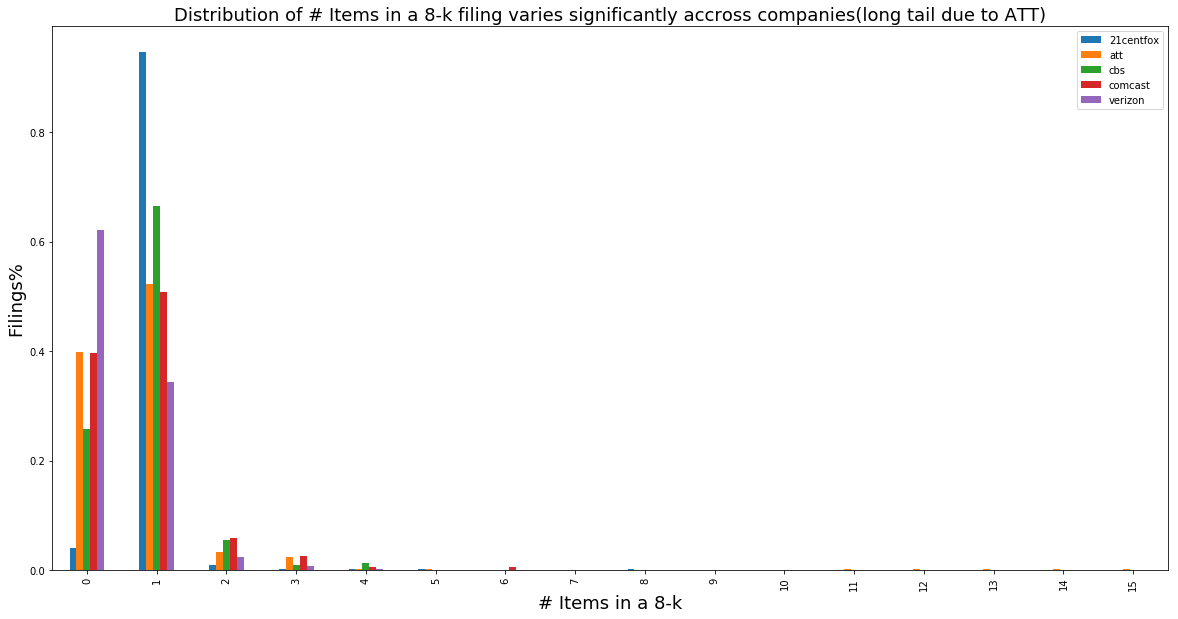

In [63]:
top20 = pd.DataFrame({'21centfox' : [0.04,0.945882,0.009412,0.001176,0.001176,
                                     0.001176,0,0,0.001176,0,
                                     0,0,0,0,0,0],
                      'att':[0.398515,0.522277,0.032178,0.024752,0.002475,
                                          0.002475,0,0,0,0,
                                          0,0.002475,0.002475,0.002475,0.002475,
                                          0.002475],
                      'cbs':[0.258475,0.665254,0.055085,0.008475,0.012712,
                                           0,0,0,0,0,0,0,0,0,0,0],
                      'comcast':[0.396825,0.507937,0.058201,0.026455,0.005291,
                                               0,0.005291,0,0,0,0,0,0,0,0,0],
                      'verizon':[0.621951,0.343902,0.024390,0.007317,0.002439,
                                             0,0,0,0,0,0,0,0,0,0,0]})
ax = top20[['21centfox', 'att','cbs','comcast','verizon']].plot(kind='bar',
             figsize=(20,10));
ax.set_alpha(0.8)
ax.set_title("Distribution of # Items in a 8-k filing varies significantly accross companies(long tail due to ATT)",fontsize=18)

#plt.figure(figsize=(20,27/5.0),facecolor='white')
plt.margins(x=.15)
ax.set_ylabel("Filings%", fontsize=18);
ax.set_xlabel("# Items in a 8-k", fontsize=18);

plt.savefig('fox_sentiment.png', bbox_inches='tight')
plt.savefig('fox_sentiment.pdf', bbox_inches='tight')

                      

In [14]:
import matplotlib.pyplot as plt


In [13]:
trace1 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='21centfoxinc_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='21centfoxinc_sec_files.csv']['percentage'],
                name = '21centfoxinc')
trace2 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='attinc_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='attinc_sec_files.csv']['percentage'],
                name = 'attinc')
trace3 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='cbscorp_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='cbscorp_sec_files.csv']['percentage'],
                name = 'cbscorp')
trace4 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='comcastcorp_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='comcastcorp_sec_files.csv']['percentage'],
                name = 'comcastcorp')
trace5 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='verizoncom_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='verizoncom_sec_files.csv']['percentage'],
                name = 'verizoncom')

data = [trace1,trace2,trace3,trace4,trace5]


iplot({
    "data":data,
    "layout":go.Layout(title="Distribution of number of Items in a 8-k filing varies significantly accross companies (long tail due to ATT)", 
                       xaxis={'title':'Num of itmes in a 8-k filing'}, 
                       yaxis={'title':'Filings%'})})

In [64]:
item_numer_distribution=all_data_8k[['sec_full_path','file_name','updated_item_category_splited_v2']]\
.groupby(['file_name','updated_item_category_splited_v2'])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['file_name','number of items', 'count'] 
item_numer_distribution

sum_item_numer_distribution = item_numer_distribution[['file_name','count']].groupby(['file_name'])\
.agg(['sum'])\
.reset_index()
sum_item_numer_distribution.columns = ['file_name', 'sum'] 
sum_item_numer_distribution

item_numer_distribution = pd.merge(item_numer_distribution, sum_item_numer_distribution, on=['file_name'])
item_numer_distribution['percentage'] = item_numer_distribution['count']/item_numer_distribution['sum']
item_numer_distribution

,file_name,number of items,count,sum,percentage
0,21centfoxinc_sec_files.csv,Item 1.,1,1690,0.000592
1,21centfoxinc_sec_files.csv,Item 1.01,19,1690,0.011243
2,21centfoxinc_sec_files.csv,Item 1.02,2,1690,0.001183
3,21centfoxinc_sec_files.csv,Item 2.,1,1690,0.000592
4,21centfoxinc_sec_files.csv,Item 2.01,2,1690,0.001183
5,21centfoxinc_sec_files.csv,Item 2.02,2,1690,0.001183
6,21centfoxinc_sec_files.csv,Item 2.03,10,1690,0.005917
7,21centfoxinc_sec_files.csv,Item 2.06,1,1690,0.000592
8,21centfoxinc_sec_files.csv,Item 3.,1,1690,0.000592
9,21centfoxinc_sec_files.csv,Item 3.01,1,1690,0.000592


In [67]:
trace1 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='21centfoxinc_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='21centfoxinc_sec_files.csv']['percentage'],
                name = '21centfoxinc')
trace2 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='attinc_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='attinc_sec_files.csv']['percentage'],
                name = 'attinc')
trace3 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='cbscorp_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='cbscorp_sec_files.csv']['percentage'],
                name = 'cbscorp')
trace4 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='comcastcorp_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='comcastcorp_sec_files.csv']['percentage'],
                name = 'comcastcorp')
trace5 = go.Bar(x = item_numer_distribution[item_numer_distribution['file_name']=='verizoncom_sec_files.csv']['number of items'], 
                y = item_numer_distribution[item_numer_distribution['file_name']=='verizoncom_sec_files.csv']['percentage'],
                name = 'verizoncom')

data = [trace1,trace2,trace3,trace4,trace5]


iplot({
    "data":data,
    "layout":go.Layout(title="Single digit v.s. two deci item due to SEC filing rule change. Topics filed by Company vary significantly", 
                       xaxis={'title':'8-k filing Itme','showgrid':False}, 
                       yaxis={'title':'Item%','showgrid':False})})

### Verizon sample

In [254]:
verizon_data = pd.read_csv('C:/Users/li haoran/Desktop/sec files/full_data_verizon.csv', sep='|', encoding='utf-8')
verizon_data_8k = verizon_data[verizon_data['form']=='8-K']
verizon_data_8k['Item_category'] =verizon_data_8k['Item_category'].str.replace('[', '').str.replace(']', '')

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [255]:
verizon_data_8k['updated_item_category'] = [list(set(list(filter(re.compile(r'^Item [0-9]+').search, i))))
 for i in verizon_data_8k['cleaned_text'].str.replace(u'\xa0', ' ').str.split('%%')]
temp = pd.DataFrame(verizon_data_8k.updated_item_category.tolist(), index=verizon_data_8k.sec_full_path).stack()
temp = temp.reset_index()[[0, 'sec_full_path']] 
temp.columns = ['updated_item_category_splited', 'sec_full_path'] 
verizon_data_8k = pd.merge(verizon_data_8k, temp, on=['sec_full_path'])

C:\Users\li haoran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [256]:
verizon_data_8k['updated_item_category_splited_v2'] = [j.group(0) if j is not None else '' 
 for j in [re.search('Item [0-9]\.[0-9]*', i) 
           for i in [re.sub(' +',' ',i) 
                     for i in verizon_data_8k['updated_item_category_splited']]]]
verizon_data_8k = verizon_data_8k[verizon_data_8k.updated_item_category_splited_v2!='']

In [265]:
verizon_data_8k

,Unnamed: 0,fdate,cik,findexdate,form,coname,fsize,doccount,sec_full_path,text,cleaned_text,raw_table,cleaned_table,Item_text,Item_category,file_name,updated_item_category,updated_item_category_splited,updated_item_category_splited_v2
0,0,1/21/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3399,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<s> <c>\r\nDate of Report: ...,"[[['Date of Report:', 'January 20, 1994'], ['E...",[' 2\n\n\n\n\nItem 5. Other Events.\n\n ...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
1,1,2/1/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2923,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"[""\n\n\n\n SECURITIES AND EXCHANGE COMMI...",'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
2,2,2/9/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,18580,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<caption>\r\n ...,"[[['', ''], ['', 'Three months endedYear ended...","["" 2\nItem 5. Other Events.\n\nBell Atlantic...","'5. Other Events.', '7. Financial Statements a...",verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial Stat...",Item 5. Other Events.,Item 5.
3,2,2/9/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,18580,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<caption>\r\n ...,"[[['', ''], ['', 'Three months endedYear ended...","["" 2\nItem 5. Other Events.\n\nBell Atlantic...","'5. Other Events.', '7. Financial Statements a...",verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial Stat...",Item 7. Financial Statements and Exhibits.,Item 7.
4,3,2/14/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,2930,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[<table>\r\n<s> <c>\r\nDate of Report: ...,"[[['Date of Report:', 'February 14, 1994'], ['...",[' 3\n\n\n\n\nItem 5. Other Events.\n\n ...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
5,4,2/24/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,3196,1,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[' 2\nItem 5. Other Events.\n\n Bell At...,'5. Other Events.',verizoncom_sec_files.csv,[Item 5. Other Events.],Item 5. Other Events.,Item 5.
6,5,3/23/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,6014,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"["" 2\n\n\nItem 5. Other Events.\n\n Attac...",'5. Other Events.',verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial St...",Item 5. Other Events.,Item 5.
7,5,3/23/1994,732712,3/31/1994,8-K,BELL ATLANTIC CORP,6014,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],"["" 2\n\n\nItem 5. Other Events.\n\n Attac...",'5. Other Events.',verizoncom_sec_files.csv,"[Item 5. Other Events., Item 7. Financial St...","Item 7. Financial Statements, Pro Forma Finan...",Item 7.
8,7,4/22/1994,732712,6/30/1994,8-K,BELL ATLANTIC CORP,13572,2,https://www.sec.gov/Archives/edgar/data/732712...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\r\nPr...,-----BEGIN PRIVACY-ENHANCED MESSAGE-----%%Proc...,[],[],[' 3 \n\nItem 5. Other Events.\n\nAttached as...,'5. Other Events.',verizoncom_sec_files.csv,"[Ite

In [259]:
verizon_data_8k['updated_item_category_splited_v2'].unique()

array(['Item 5.', 'Item 7.', 'Item 6.', 'Item 1.', 'Item 2.', 'Item 4.',
       'Item 9.', 'Item 8.01', 'Item 2.02', 'Item 1.01', 'Item 9.01',
       'Item 5.02', 'Item 5.03', 'Item 2.01', 'Item 2.04', 'Item 7.01',
       'Item 3.01', 'Item 2.03', 'Item 5.07', 'Item 1.02'], dtype=object)

In [263]:
item_numer_distribution=verizon_data_8k[['sec_full_path','updated_item_category_splited_v2']]\
.groupby(['sec_full_path'])\
.agg(['count'])\
.reset_index()\
.groupby([('updated_item_category_splited_v2','count')])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['number of items', 'count'] 

In [264]:
item_numer_distribution

,number of items,count
0,1,255
1,2,141
2,3,10
3,4,3
4,5,1


In [267]:
trace1 = go.Bar(x = item_numer_distribution['number of items'], 
                y = item_numer_distribution['count'],
                name = 'filing count')

trace2 = go.Bar(x = item_numer_distribution['number of items'], 
                y = item_numer_distribution['count'],
                name = 'filing count')

data = [trace1,trace2]


iplot({
    "data":data,
    "layout":go.Layout(title="Distribution of number of emails received", 
                       xaxis={'title':'Num of emails'}, 
                       yaxis={'title':'Percentage of people received %'})})

## Moody's score

In [60]:
path = "C:/Users/li haoran/Documents/GitHub/Capstone_Vanguard_NLP_Prediction/Inputs/Columbia DSIC 2018 - Moody's data.xlsx"
moody = pd.read_excel(path)
conditions = [
    (moody['Change'] == 'Same'),
    (moody['Change'] == 'Up'),
    (moody['Change'] == 'Down'),
    (moody['Change'] == 'Initial')]
choices = [0, 1, -1, 0]
moody['Change_num'] = np.select(conditions, choices)


conditions = [
    (moody['Change_num'] == -1),
    (moody['Change_num'] == 0),
    (moody['Change_num'] == 1)]
choices = ['Down', 'Same','Up']
moody['Change_cat'] = np.select(conditions, choices)
moody

,Company,Moody's Rating,Watch,Type,Effective Date,Change,Change_num,Change_cat
0,21st Century Fox America,Baa1,+,up,2017-12-14,Same,0,Same
1,21st Century Fox America,Baa1,NaN,up,2016-12-15,Same,0,Same
2,21st Century Fox America,Baa1,-,down,2016-12-12,Same,0,Same
3,21st Century Fox America,Baa1,NaN,up,2008-06-11,Up,1,Up
4,21st Century Fox America,Baa2,+,up,2008-04-16,Same,0,Same
5,21st Century Fox America,Baa2,NaN,up,2005-11-21,Up,1,Up
6,21st Century Fox America,Baa3,+,up,2005-09-22,Same,0,Same
7,21st Century Fox America,Baa3,-,down,2005-01-25,Same,0,Same
8,21st Century Fox America,Baa3,+,up,2004-04-26,Same,0,Same
9,21st Century Fox America,Baa3,NaN,up,1996-10-01,Up,1,Up


In [48]:
item_numer_distribution=moody[['Company','Change',"Moody's Rating"]]\
.groupby(['Company','Change'])\
.agg(['count'])\
.reset_index()
item_numer_distribution.columns = ['Company',"Moody's Score Change", 'count'] 
item_numer_distribution

,Company,Moody's Score Change,count
0,21st Century Fox America,Initial,1
1,21st Century Fox America,Same,7
2,21st Century Fox America,Up,5
3,AT&T Corp,Down,11
4,AT&T Corp,Initial,1
5,AT&T Corp,Same,10
6,AT&T Corp,Up,3
7,CBS Corp,Down,1
8,CBS Corp,Initial,1
9,CBS Corp,Same,4


In [49]:
trace1 = go.Bar(x = item_numer_distribution[item_numer_distribution['Company']=='21st Century Fox America']["Moody's Score Change"], 
                y = item_numer_distribution[item_numer_distribution['Company']=='21st Century Fox America']['count'],
                name = '21centfoxinc',
                text = item_numer_distribution[item_numer_distribution['Company']=='21st Century Fox America']['count'],
                textposition = 'auto')
trace2 = go.Bar(x = item_numer_distribution[item_numer_distribution['Company']=='AT&T Corp']["Moody's Score Change"], 
                y = item_numer_distribution[item_numer_distribution['Company']=='AT&T Corp']['count'],
                name = 'attinc',
                text = item_numer_distribution[item_numer_distribution['Company']=='AT&T Corp']['count'],
                textposition = 'auto')
trace3 = go.Bar(x = item_numer_distribution[item_numer_distribution['Company']=='CBS Corp']["Moody's Score Change"], 
                y = item_numer_distribution[item_numer_distribution['Company']=='CBS Corp']['count'],
                name = 'cbscorp',
                text = item_numer_distribution[item_numer_distribution['Company']=='CBS Corp']['count'],
                textposition = 'auto')
trace4 = go.Bar(x = item_numer_distribution[item_numer_distribution['Company']=='Comcast Corp']["Moody's Score Change"], 
                y = item_numer_distribution[item_numer_distribution['Company']=='Comcast Corp']['count'],
                name = 'comcastcorp',
                text = item_numer_distribution[item_numer_distribution['Company']=='Comcast Corp']['count'],
                textposition = 'auto')                
trace5 = go.Bar(x = item_numer_distribution[item_numer_distribution['Company']=='Verizon Communications Inc']["Moody's Score Change"], 
                y = item_numer_distribution[item_numer_distribution['Company']=='Verizon Communications Inc']['count'],
                name = 'verizoncom',
                text = item_numer_distribution[item_numer_distribution['Company']=='Verizon Communications Inc']['count'],
                textposition = 'auto')                                

data = [trace1,trace2,trace3,trace4,trace5]


iplot({
    "data":data,
    "layout":go.Layout(title="Limited Moddy's Scores and Moddy's Score Changes ", 
                       xaxis={'title':"How Moddy's score change"}, 
                       yaxis={'title':'Count'})})

In [56]:
moody = moody.sort_values(by=['Company','Effective Date','Change'])
moody =

,Company,Moody's Rating,Watch,Type,Effective Date,Change,Change_num
12,21st Century Fox America,B1,NaN,up,1991-11-27,Initial,0
11,21st Century Fox America,Ba2,NaN,up,1992-10-09,Up,1
10,21st Century Fox America,Ba1,NaN,up,1993-10-14,Up,1
9,21st Century Fox America,Baa3,NaN,up,1996-10-01,Up,1
8,21st Century Fox America,Baa3,+,up,2004-04-26,Same,0
7,21st Century Fox America,Baa3,-,down,2005-01-25,Same,0
6,21st Century Fox America,Baa3,+,up,2005-09-22,Same,0
5,21st Century Fox America,Baa2,NaN,up,2005-11-21,Up,1
4,21st Century Fox America,Baa2,+,up,2008-04-16,Same,0
3,21st Century Fox America,Baa1,NaN,up,2008-06-11,Up,1


In [88]:
labels = ['Television', 'Newspaper', 'Internet']

trace1 = go.Scatter(x = moody[moody['Company']=='21st Century Fox America']["Effective Date"], 
                y = moody[moody['Company']=='21st Century Fox America']['Change_cat'],
                name = '21centfoxinc')
trace2 = go.Scatter(x = moody[moody['Company']=='AT&T Corp']["Effective Date"], 
                y = moody[moody['Company']=='AT&T Corp']['Change_cat'],
                name = 'attinc')
trace3 = go.Scatter(x = moody[moody['Company']=='CBS Corp']["Effective Date"], 
                y = moody[moody['Company']=='CBS Corp']['Change_cat'],
                name = 'cbscorp')
trace4 = go.Scatter(x = moody[moody['Company']=='Comcast Corp']["Effective Date"], 
                y = moody[moody['Company']=='Comcast Corp']['Change_cat'],
                name = 'comcastcorp')                
trace5 = go.Scatter(x = moody[moody['Company']=='Verizon Communications Inc']["Effective Date"], 
                y = moody[moody['Company']=='Verizon Communications Inc']['Change_cat'],
                name = 'verizoncom')                                

data = [trace1,trace2,trace3,trace4,trace5]


iplot({
    "data":data,
    "layout":go.Layout(title= "ATT went up & down, 21Cent mono-inc., Verizon mono-dec., CBS & Comcast almost mono-inc e.g CBS, Comcast" ,  
                       xaxis={'title':"How Moddy's score change"})})

In [52]:
labels = ['Television', 'Newspaper', 'Internet']

trace1 = go.Scatter(x = moody[moody['Company']=='21st Century Fox America']["Effective Date"], 
                y = moody[moody['Company']=='21st Century Fox America']['Change'],
                name = '21centfoxinc')
trace2 = go.Scatter(x = moody[moody['Company']=='AT&T Corp']["Effective Date"], 
                y = moody[moody['Company']=='AT&T Corp']['Change'],
                name = 'attinc')
trace3 = go.Scatter(x = moody[moody['Company']=='CBS Corp']["Effective Date"], 
                y = moody[moody['Company']=='CBS Corp']['Change'],
                name = 'cbscorp')
trace4 = go.Scatter(x = moody[moody['Company']=='Comcast Corp']["Effective Date"], 
                y = moody[moody['Company']=='Comcast Corp']['Change'],
                name = 'comcastcorp')                
trace5 = go.Scatter(x = moody[moody['Company']=='Verizon Communications Inc']["Effective Date"], 
                y = moody[moody['Company']=='Verizon Communications Inc']['Change'],
                name = 'verizoncom')                                

data = [trace1,trace2,trace3,trace4,trace5]


iplot({
    "data":data,
    "layout":go.Layout(title="Limited Moddy's Scores and Moddy's Score Changes ", 
                       xaxis={'title':"How Moddy's score change"}, 
                       yaxis={'title':'Count'})})